In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output


In [225]:
# import spectroscopy data 
X = pd.read_csv('RamanSpectra.csv', header=None).to_numpy()            #Spectra
y = pd.read_csv('RamanConcentrations.csv', header=None).to_numpy()     #Concentrations
S = pd.read_csv('RamanShifts.csv', header=None).to_numpy()             #Raman Shifts
Species = ['Kyanite','Wollastonite','Olivine','Silica','Zircon'] # different insoluble GFCs for raman spec. 


In [ ]:
# test train split: (Not required)
X_train, X_test, y_train, y_test = train_test_split(S, X[1, :], test_size = 0.2, random_state= 1)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Epoch 101
-------------------------------
loss: 0.000959  
Epoch 201
-------------------------------
loss: 0.000147  
Epoch 301
-------------------------------
loss: 0.000063  
Epoch 401
-------------------------------
loss: 0.000288  
Epoch 501
-------------------------------
loss: 0.000087  
Epoch 601
-------------------------------
loss: 0.000199  
Epoch 701
-------------------------------
loss: 0.000021  
Epoch 801
-------------------------------
loss: 0.000033  
Epoch 901
-------------------------------
loss: 0.000018  
Done!


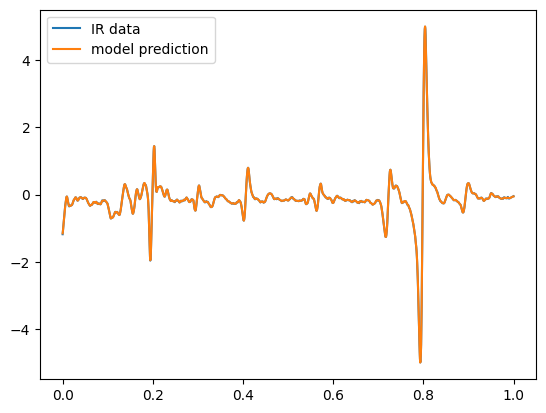

In [226]:
# NN for interpolation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Normalize
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Import StandardScaler from scikit-learn
import time

# 'input_data' and 'output_data' into the neural net
output_data_np = signal.savgol_filter(X[1,:], window_length = 19, polyorder = 2, deriv = 1)  # spectral intensity (y axis) 
print(output_data_np.shape)
y_plot = np.copy(output_data_np.reshape(-1, 1))
input_data_np = S   # wavelengths (x axis)
x_plot = np.copy(input_data_np.reshape(-1, 1))

# Standard scaling for input data
#input_scaler = StandardScaler()
input_scaler = MinMaxScaler()
input_data_np = input_scaler.fit_transform(input_data_np)

# Standard scaling for output data
#output_scaler = StandardScaler()
output_scaler = MinMaxScaler(feature_range=(-5, 5))
output_data_np = output_scaler.fit_transform(output_data_np.reshape(-1, 1))

# convert to torch tensor
input_data = torch.tensor(input_data_np, dtype=torch.float32)
output_data = torch.tensor(output_data_np, dtype=torch.float32)

# Step 4: Create the neural network architecture
class InterpolationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu_stack = torch.nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        temp = self.relu_stack(x)
        return temp

model = InterpolationModel()

# Step 5: Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train(in_data, out_data, model, loss_fn, optimizer):
    freqs = torch.tensor([i+0.25 for i in range(20)], dtype=torch.float32, requires_grad=False)
    sin_layer = torch.sin(in_data * freqs * 2 * torch.pi)
    model.train()
    # Compute prediction error
    pred = model(sin_layer)
    loss = loss_fn(pred, out_data)
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
epochs = 1000
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        freqs = torch.tensor([i+0.25 for i in range(20)], dtype=torch.float32)
        sin_layer = torch.sin(input_data * freqs * 2 * torch.pi)
        pred = model(sin_layer)
        print(f"loss: {loss_fn(pred,output_data):>7f}  ")
    if t % 1000 == 0:
        clear_output(wait=True)
    train(input_data, output_data, model, loss_fn, optimizer)
print("Done!")
plt.plot(input_data, output_data, label='IR data')
freqs = torch.tensor([i+0.25 for i in range(20)], dtype=torch.float32)
sin_layer = torch.sin(input_data * freqs * 2 * torch.pi)
plt.plot(input_data, model(sin_layer).detach().numpy(), label='model prediction')
plt.legend()

In [223]:
output_data.shape

torch.Size([784, 1])

ValueError: x and y must have same first dimension, but have shapes (1601, 1) and (784, 1)

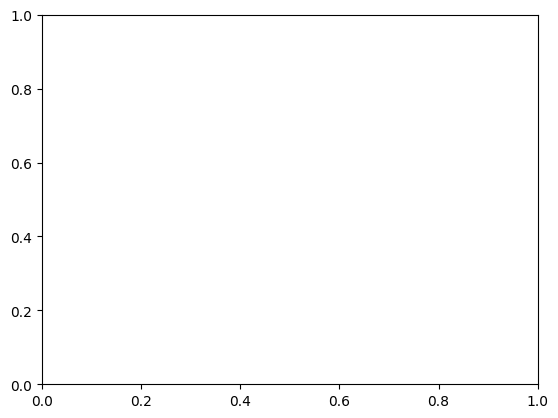

In [222]:
# plot of raman spectrum with SG filter
#plt.plot(S, signal.savgol_filter(X[1, :], window_length = 19, polyorder = 2, deriv = 1))
plt.plot(x_plot, y_plot)
plt.plot(S, predictions)
plt.xlabel("Raman Shift")
plt.ylabel("Counts or Intensity")
plt.title("Raman Spectroscopy")

### Familiarizing with pyTorch

In [210]:
x_data = torch.tensor(np.linspace(0, 1, 100),dtype=torch.float32).reshape(-1,1)
toy_data = torch.sin(2*np.pi*x_data)

In [218]:
# Define model
class linearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = linearModel()
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

def train(in_data, out_data, model, loss_fn, optimizer):
    freqs = torch.tensor([i+0.25 for i in range(2)], dtype=torch.float32, requires_grad=False)
    sin_layer = torch.sin(in_data * freqs * 2 * torch.pi)
    model.train()
    # Compute prediction error
    pred = model(sin_layer)
    loss = loss_fn(pred, out_data)
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

linearModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


Epoch 9101
-------------------------------
loss: 0.000194  
Epoch 9201
-------------------------------
loss: 0.000202  
Epoch 9301
-------------------------------
loss: 0.000230  
Epoch 9401
-------------------------------
loss: 0.000261  
Epoch 9501
-------------------------------
loss: 0.001297  
Epoch 9601
-------------------------------
loss: 0.000230  
Epoch 9701
-------------------------------
loss: 0.000197  
Epoch 9801
-------------------------------
loss: 0.000198  
Epoch 9901
-------------------------------
loss: 0.000200  
Done!


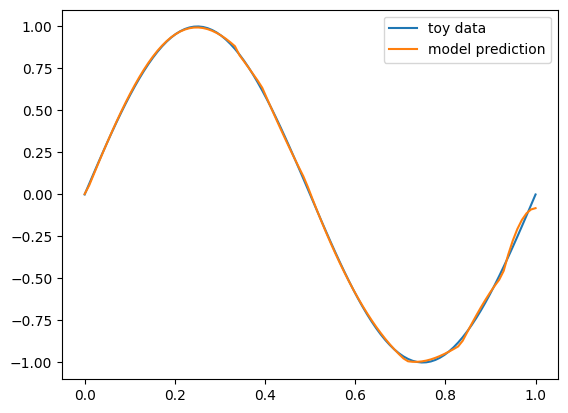

In [219]:
epochs = 10000
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        freqs = torch.tensor([i+0.25 for i in range(2)], dtype=torch.float32)
        sin_layer = torch.sin(x_data * freqs * 2 * torch.pi)
        pred = model(sin_layer)
        print(f"loss: {loss_fn(pred,toy_data):>7f}  ")
    if t % 1000 == 0:
        clear_output(wait=True)
    train(x_data, toy_data, model, loss_fn, optimizer)
print("Done!")
plt.plot(x_data, toy_data, label='toy data')
freqs = torch.tensor([i+0.25 for i in range(2)], dtype=torch.float32)
sin_layer = torch.sin(x_data * freqs * 2 * torch.pi)
plt.plot(x_data, model(sin_layer).detach().numpy(), label='model prediction')
plt.legend()

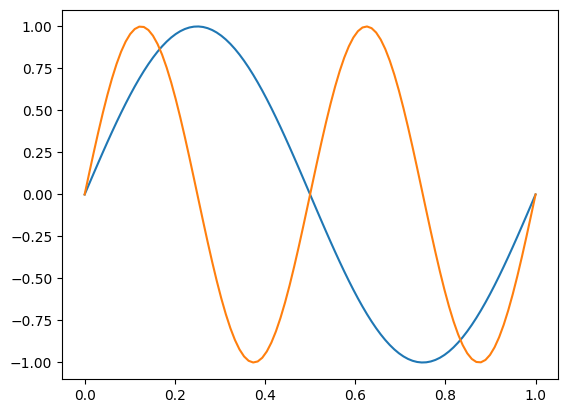

In [200]:
freqs = torch.tensor([i+1 for i in range(2)], dtype=torch.float32)
sin_layer = torch.sin(x_data * freqs * 2 * torch.pi)
for i in range(2):
    plt.plot(x_data, sin_layer[:,i], label='model prediction')

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from IPython.display import clear_output

In [57]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

In [58]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [59]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [61]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            print(X)
            print(X.shape)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [62]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310739  [   64/60000]
loss: 2.290692  [ 6464/60000]
loss: 2.275922  [12864/60000]
loss: 2.272576  [19264/60000]
loss: 2.252334  [25664/60000]
loss: 2.236569  [32064/60000]
loss: 2.242652  [38464/60000]
loss: 2.212395  [44864/60000]
loss: 2.204222  [51264/60000]
loss: 2.175187  [57664/60000]
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0